# Perona-Malik anisotropic diffusion

Experiments to validate anisotropy in DeltaConv and compare to other intrinsic convolutions.
This notebook outputs the figures as shown in the paper in Figure 2 of the main paper and Figure 2, 3 of the supplement.

First, we need to install a couple of libraries that are only required for this notebook and not for the rest of the codebase.

In [ ]:
%pip install kornia matplotlib scikit-image

Import the necessary libraries.

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import kornia as K
from skimage import data, color
from skimage.transform import rescale

Let's load and show some of the sample images provided by the Scikit Image toolbox.

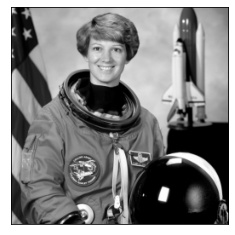

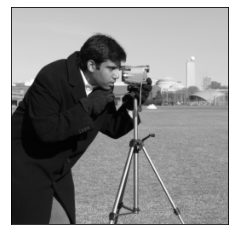

In [2]:
# Define a convenience function to plot images
def imshow(input: torch.Tensor, ax=None, outline=True):
    """Shows one image given as a torch Tensor.
    
    Args:
        input (Tensor): the image to be shown.
        ax (axis, optional): if provided, will plot the image in the given axis (default: None).
        outline (bool, optional): if set to true, will show an outline around the image (default: True).
        """
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = K.utils.tensor_to_image(out)
    if ax: 
        ax.imshow((out_np.clip(0, 1) * 255).astype(np.uint8))
        if outline:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            ax.axis('off')
    else:
        plt.imshow((out_np.clip(0, 1) * 255).astype(np.uint8))
        if outline:
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            plt.axis('off')
        plt.show()

# Load images into a dictionary for ease of access
images = {}
images['astronaut'] = K.utils.image_to_tensor(rescale(color.rgb2gray(data.astronaut()), 0.5)).float()[None]
images['camera'] = K.utils.image_to_tensor(rescale(data.camera(), 0.5)).float()[None]

# And show the images
imshow(images['astronaut'])
imshow(images['camera'])

## Anisotropic Diffusion

Next, we create an anisotropic diffusion function that explicitly computes anisotropic diffusion for one timestep.

This implementation follows the anisotropic diffusion equation [described by Pietro Perona and Jitendra Malik](https://authors.library.caltech.edu/6498/1/PERieeetpami90.pdf) (equation 3).
Both non-linearities described in the Perona-Malik paper are implemented and can be selected with the `c_func` parameter.

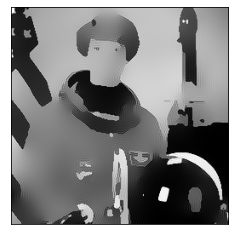

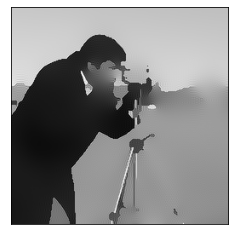

In [3]:
def anisotropic_diffusion(image, kappa=0.05, c_func='exp'):
    """Applies one step of anisotropic diffusion.
    The parameter K and c_func parameters influence the non-linearity applied to the gradient norms.
    """
    # Compute the gradient
    grads = K.filters.spatial_gradient(image, order=1)
    grads_x = grads[:, :, 0]
    grads_y = grads[:, :, 1]

    # Apply a non-linearity to the norm of the gradient
    grad_norm = np.sqrt(grads_x ** 2 + grads_y ** 2)
    if c_func == 'exp':
        c = np.exp(-(grad_norm / kappa) ** 2)
    else:
        c = 1 / (1 + grad_norm / kappa) ** 2

    # Scale the gradient with the non-linearity
    grads_x = c * grads_x
    grads_y = c * grads_y

    # Apply divergence
    div = (
        K.filters.spatial_gradient(grads_x, order=1)[:, :, 0]
        + K.filters.spatial_gradient(grads_y, order=1)[:, :, 1]
    )
    return image + div

def anisotropic_diffusion_nsteps(image, n):
    """Applies anisotropic diffusion on an input image for n steps."""
    im_blurred = image
    for i in range(n):
        im_blurred = anisotropic_diffusion(im_blurred, kappa=0.05, c_func='exp')
    return im_blurred

# Test on a sample image with a very large number of timesteps
im_anisotropic_astronaut = anisotropic_diffusion_nsteps(images['astronaut'], 100)
im_anisotropic_camera = anisotropic_diffusion_nsteps(images['camera'], 100)
imshow(im_anisotropic_astronaut)
imshow(im_anisotropic_camera)

# Convolution operators and architecture

Create all the networks to be tested: CNNs, DeltaNet, DiffusionNet, DGCNN, PointNet++, GCN.

We reimplemented seven graph/surface/point cloud convolution operators to work on images.
The architecture is a ResNet with `num_layers` depth, and `out_channels` width.

Please see the file `architectures.py` for the reimplementation of each network.

In [4]:
from architectures import *

## Training the networks

We train each network for 200 iterations and inspect the result.

In [5]:
iterations = 200
torch.manual_seed(1)

# Network settings
num_layers = 16     # Depth of the network
out_channels = 16   # Width of the network in hidden layers
in_channels = 1     # Number of input channels (we're working on grayscale images)

# Device to train on
device = torch.device('cuda')

# Network configurations
def config(net, num_layers, out_channels, in_channels, device=torch.device('cuda'), optimizer=torch.optim.Adam, lr=1e-3, scheduler=torch.optim.lr_scheduler.StepLR, loss=torch.nn.L1Loss):
    config = {'net': net(num_layers, out_channels, in_channels).to(device)}
    config['optimizer'] = optimizer(config['net'].parameters(), lr=lr, weight_decay=1e-5)
    config['scheduler'] = scheduler(config['optimizer'], step_size=50)
    config['loss_func'] = loss()
    return config

# Load the networks to be trained
nets = [DeltaNet, EdgeNet, PointNet, GCN, DiffusionNet, ConvNet]

# Train the networks
def train(nets, input, target):

    input = input.to(device)
    target = target.to(device)

    pred_images = []
    for net in nets:
        c = config(net, num_layers, out_channels, in_channels, device)
        c['net'].train()
        for _ in range(iterations):
            c['optimizer'].zero_grad()
            pred = c['net'](input)
            loss = c['loss_func'](pred, target)
            loss.backward()
            c['optimizer'].step()
            c['scheduler'].step()

        c['net'].eval()
        pred_images.append(c['net'](input.to(device)).detach().to('cpu'))
    return pred_images

## Comparisons

Finally, it's time to train the network on a given number of timesteps and show the results.
These figures correspond to Figure 2 in the main paper and Figure 2 in the supplement.

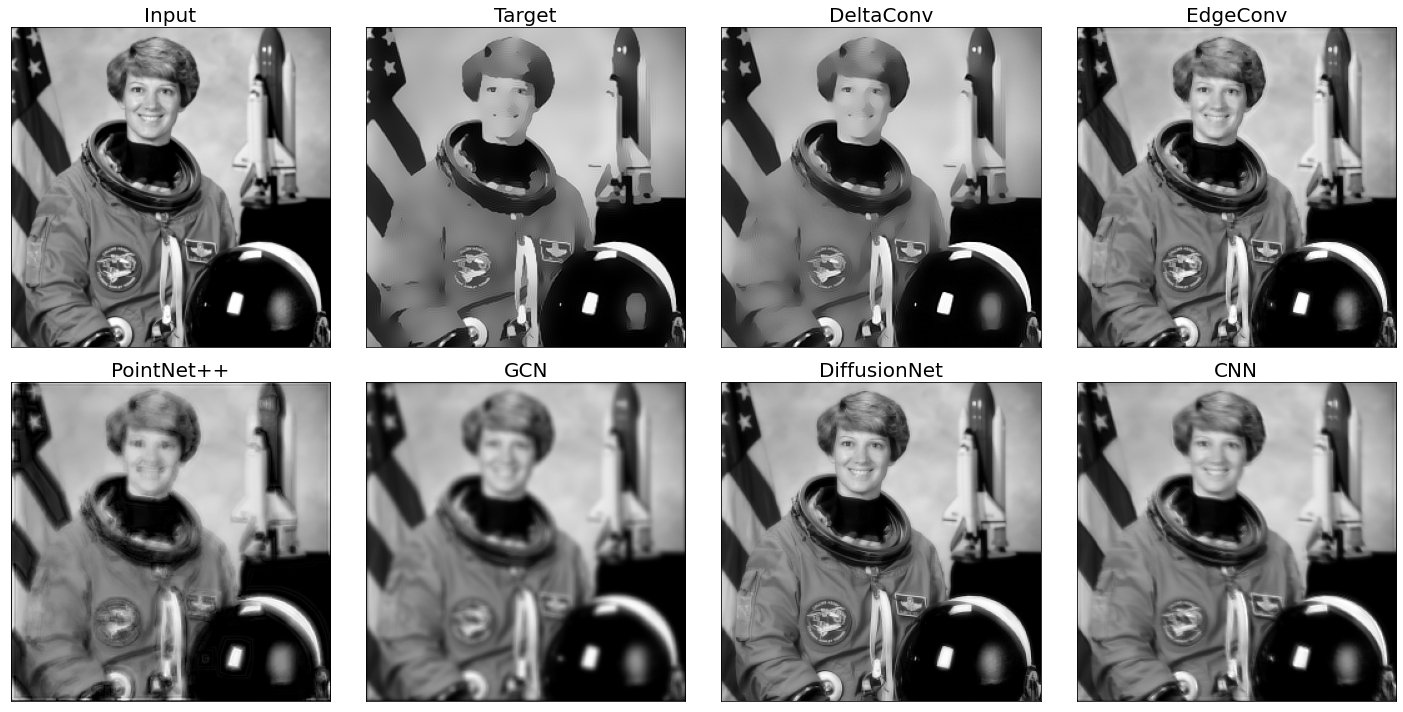

In [6]:
# Optional: set fonts to linux libertine to exactly match the figures in the paper.
# import matplotlib.font_manager as font_manager
# from matplotlib.font_manager import _rebuild; _rebuild()
# # Set path to the directory where you have installed the font.
# fontpath = '/usr/share/fonts/opentype/linux-libertine/LinBiolinum_R.otf'
# prop = font_manager.FontProperties(fname=fontpath)
# plt.rcParams["font.family"] = prop.get_name()
plt.rcParams["axes.titlesize"] = 20

def single_n(input, n=50):
    """Sets up a training sample from an input image
    and a given number of timesteps for anisotropic diffusion, n
    then trains each of the networks on the input-target pair.
    """
    # Compute the target image.
    target = anisotropic_diffusion_nsteps(input, n)
    # Train each network on the input-target pair.
    out = train(nets, input, target)

    # Plot the outputs in a 2-row grid.
    n_output = len(out)
    n_rows = 2
    n_cols = (2 + n_output) // n_rows

    # Create the subplots
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    fig.set_size_inches((2 + n_output) * 6, 10)
    imshow(input.to('cpu'), ax[0][0])
    ax[0][0].set_title('Input')
    imshow(target.to('cpu'), ax[0][1])
    ax[0][1].set_title('Target')

    for i, pred_image in enumerate(out):
        idx = 2 + i
        row, col = idx // n_cols, idx % n_cols
        imshow(pred_image, ax[row][col])
        ax[row][col].set_title(nets[i].name())

    fig.tight_layout()
    plt.subplots_adjust(wspace=-0.85)
    plt.show()

# Run the experiment on the camera input image and 20 anisotropic diffusion steps.
# Figure 2 of the main paper.
single_n(images['astronaut'], 20)

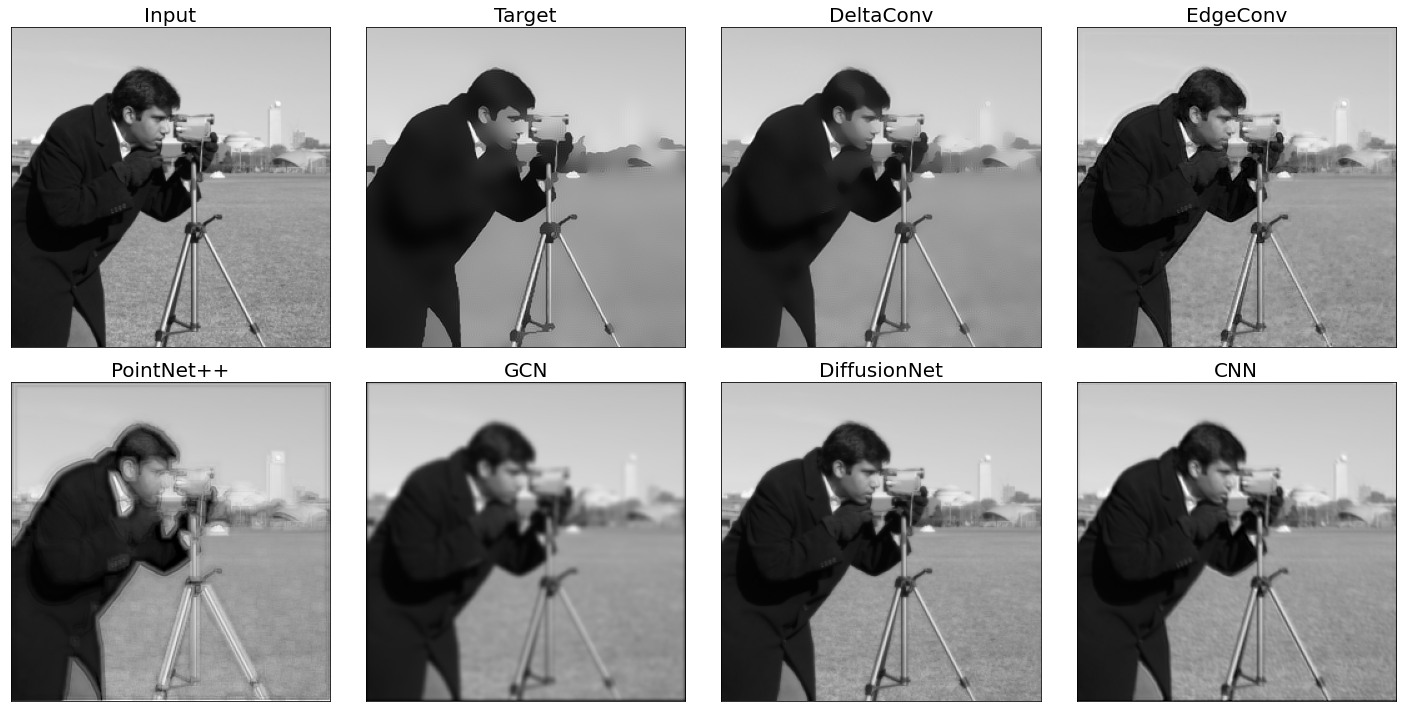

In [7]:
# Run the experiment on the astronaut input image and 20 anisotropic diffusion steps.
# Figure 2 of the supplement.
single_n(images['camera'], 20)

## Learning diffusion times

Next, we experiment with the ability of DeltaConv to optimize to specific diffusion times.
We generate a set of target images and optimize for each.

The output of this experiment is seen in Figure 3 in the supplement.

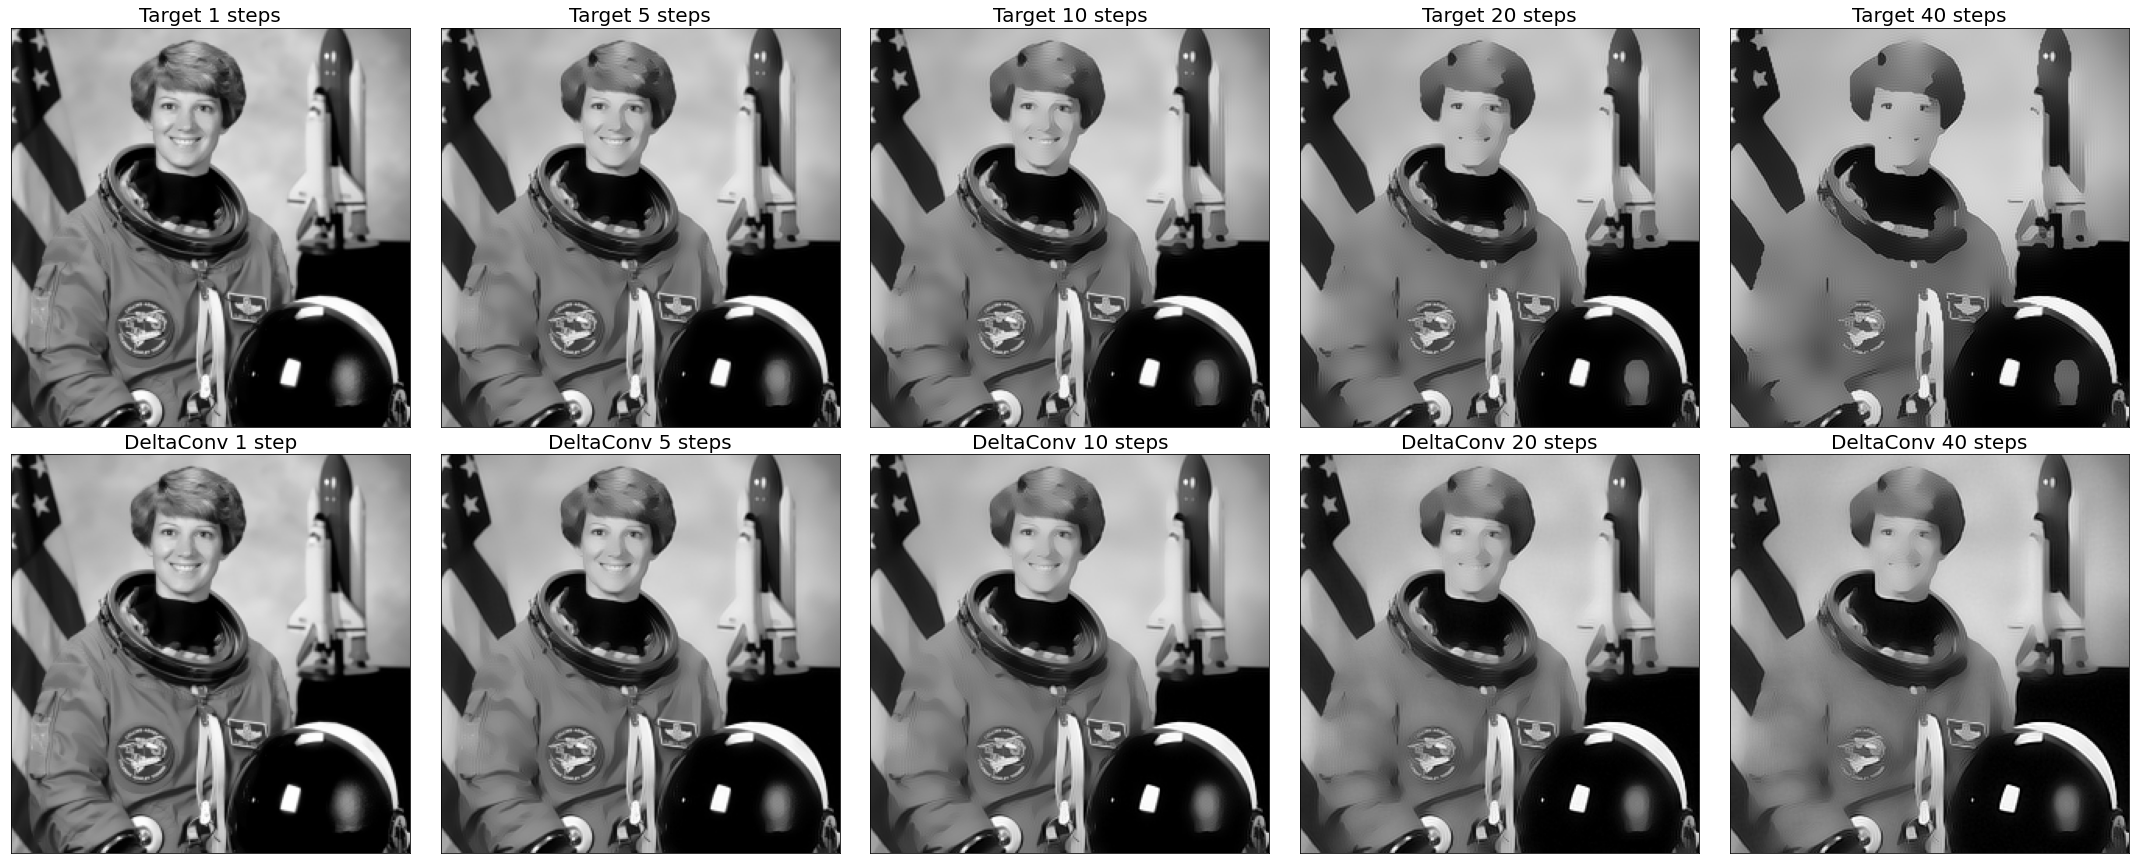

In [8]:
def multiple_n(input, ns=[1, 5, 10, 20, 40]):
    """Set up a target image for each of the diffusion times given in ns
    and train DeltaNet on the input-target pair.
    """
    out_list = []
    target_list = []
    for n in ns:
        target = anisotropic_diffusion_nsteps(input, n)
        target_list.append(target)
        out_list.append(train([DeltaNet], input, target))

    n_output = len(out_list[0])
    n_rows = n_output + 1
    n_cols = len(ns)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    fig.set_size_inches(6 * n_cols, 6 * n_rows)

    for i, n in enumerate(ns):
        imshow(target_list[i].detach().to('cpu'), ax[0][i])
        ax[0][i].set_title('Target {} steps'.format(n))

        for j, pred_image in enumerate(out_list[i]):
            imshow(pred_image, ax[j + 1][i])
            ax[j + 1][i].set_title('{} {} step{}'.format(nets[j].name(), n, 's' if n > 1 else ''))

    fig.tight_layout()
    plt.show()

# Figure 3 of the supplement
multiple_n(images['astronaut'])